<h1>Crimes registados (N.º) pelas autoridades policiais</h1>

<a href="https://dados.gov.pt/pt/datasets/crimes-registados-n-o-pelas-autoridades-policiais/#_">https://dados.gov.pt/pt/datasets/crimes-registados-n-o-pelas-autoridades-policiais/#_</a>

<h2>Library</h2>

In [1]:
import urllib.request, json
import ssl
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

<h2>Main</h2>

In [2]:
# Disable SSL certificate verification to avoid error
ssl._create_default_https_context = ssl._create_unverified_context

url = "https://www.ine.pt/ine/json_indicador/pindica.jsp?op=2&varcd=0008073&lang=PT"
response = urllib.request.urlopen(url)
data = json.loads(response.read().decode())

In [3]:
#print(json.dumps(data, indent=4))

In [4]:
# Data available until 2022
for item in data:
    df = pd.json_normalize(item["Dados"]['2022'])

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5504 entries, 0 to 5503
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   geocod           5504 non-null   object
 1   geodsg           5504 non-null   object
 2   dim_3            5504 non-null   object
 3   dim_3_t          5504 non-null   object
 4   ind_string       5504 non-null   object
 5   valor            4482 non-null   object
 6   sinal_conv       1022 non-null   object
 7   sinal_conv_desc  1022 non-null   object
dtypes: object(8)
memory usage: 344.1+ KB


In [5]:
# Remove NA with zero
df.fillna(0, inplace=True)

# Transform Valor into int
df['valor'] = df['valor'].astype(int)

# Revome Total from dataframe
df_filtered = df[~df['dim_3_t'].str.contains('Total')]

# Remove geo totals from dataframe
df_filtered = df_filtered[~df_filtered['geodsg'].str.contains('Região|Portugal|Continente|Norte|Centro|Área')]

# Remove unnecessary columns
df_filtered.drop(columns={'geocod','dim_3','sinal_conv','sinal_conv_desc'}, inplace=True)

# Rename columns
df_filtered.rename(columns={'geodsg':'city','dim_3_t':'crime', 'valor':'value'}, inplace=True)

In [6]:
df_filtered['crime'].value_counts()

Crimes previstos em legislação avulsa                                 328
Condução sem habilitação legal                                        328
Crimes contra a integridade física                                    328
Crimes contra as pessoas                                              328
Crimes contra animais de companhia                                    328
Crimes de homicídio voluntário consumado                              328
Violência doméstica contra cônjuge ou análogos                        328
Ofensa à integridade física voluntária simples                        328
Crimes contra o património                                            328
Roubo por esticão e na via pública                                    328
Furto de veículo e em veículo motorizado                              328
Crimes contra a identidade cultural e integridade pessoal             328
Crimes contra a vida em sociedade                                     328
Condução de veículo com taxa de álcool

In [7]:
# Sort the cities alphabetically
sorted_unique_cities = np.sort(df_filtered['city'].unique())
sorted_unique_cities

array(['Abrantes', 'Aguiar da Beira', 'Alandroal', 'Albergaria-a-Velha',
       'Albufeira', 'Alcanena', 'Alcobaça', 'Alcochete', 'Alcoutim',
       'Alcácer do Sal', 'Alenquer', 'Alentejo', 'Alentejo Central',
       'Alentejo Litoral', 'Alfândega da Fé', 'Algarve', 'Alijó',
       'Aljezur', 'Aljustrel', 'Almada', 'Almeida', 'Almeirim',
       'Almodôvar', 'Alpiarça', 'Alter do Chão', 'Alto Alentejo',
       'Alto Minho', 'Alto Tâmega', 'Alvaiázere', 'Alvito', 'Amadora',
       'Amarante', 'Amares', 'Anadia', 'Angra do Heroísmo', 'Ansião',
       'Arcos de Valdevez', 'Arganil', 'Armamar', 'Arouca', 'Arraiolos',
       'Arronches', 'Arruda dos Vinhos', 'Ave', 'Aveiro', 'Avis',
       'Azambuja', 'Baixo Alentejo', 'Baião', 'Barcelos', 'Barrancos',
       'Barreiro', 'Batalha', 'Beira Baixa', 'Beiras e Serra da Estrela',
       'Beja', 'Belmonte', 'Benavente', 'Bombarral', 'Borba', 'Boticas',
       'Braga', 'Bragança', 'Cabeceiras de Basto', 'Cadaval',
       'Caldas da Rainha', 'Calhe

In [8]:
# Count of cities: 325
len(sorted_unique_cities)


325

In [9]:
# Save dataframe into a csv
df_filtered.to_csv('csv/df_cities_crimes.csv', index_label=False)

In [10]:
df_most_dangerous_cities = df_filtered.groupby(['city'])['value'].sum().sort_values(ascending=False).head(50).reset_index()

df_top5 = df_filtered[df_filtered['city'].isin(df_most_dangerous_cities['city'])]

df_top5.head()

,city,crime,ind_string,value
48,Oeste,Crimes previstos em legislação avulsa,976,976
49,Oeste,Condução sem habilitação legal,681,681
51,Oeste,Crimes contra a integridade física,1 690,1690
52,Oeste,Crimes contra as pessoas,2 667,2667
53,Oeste,Crimes contra animais de companhia,75,75


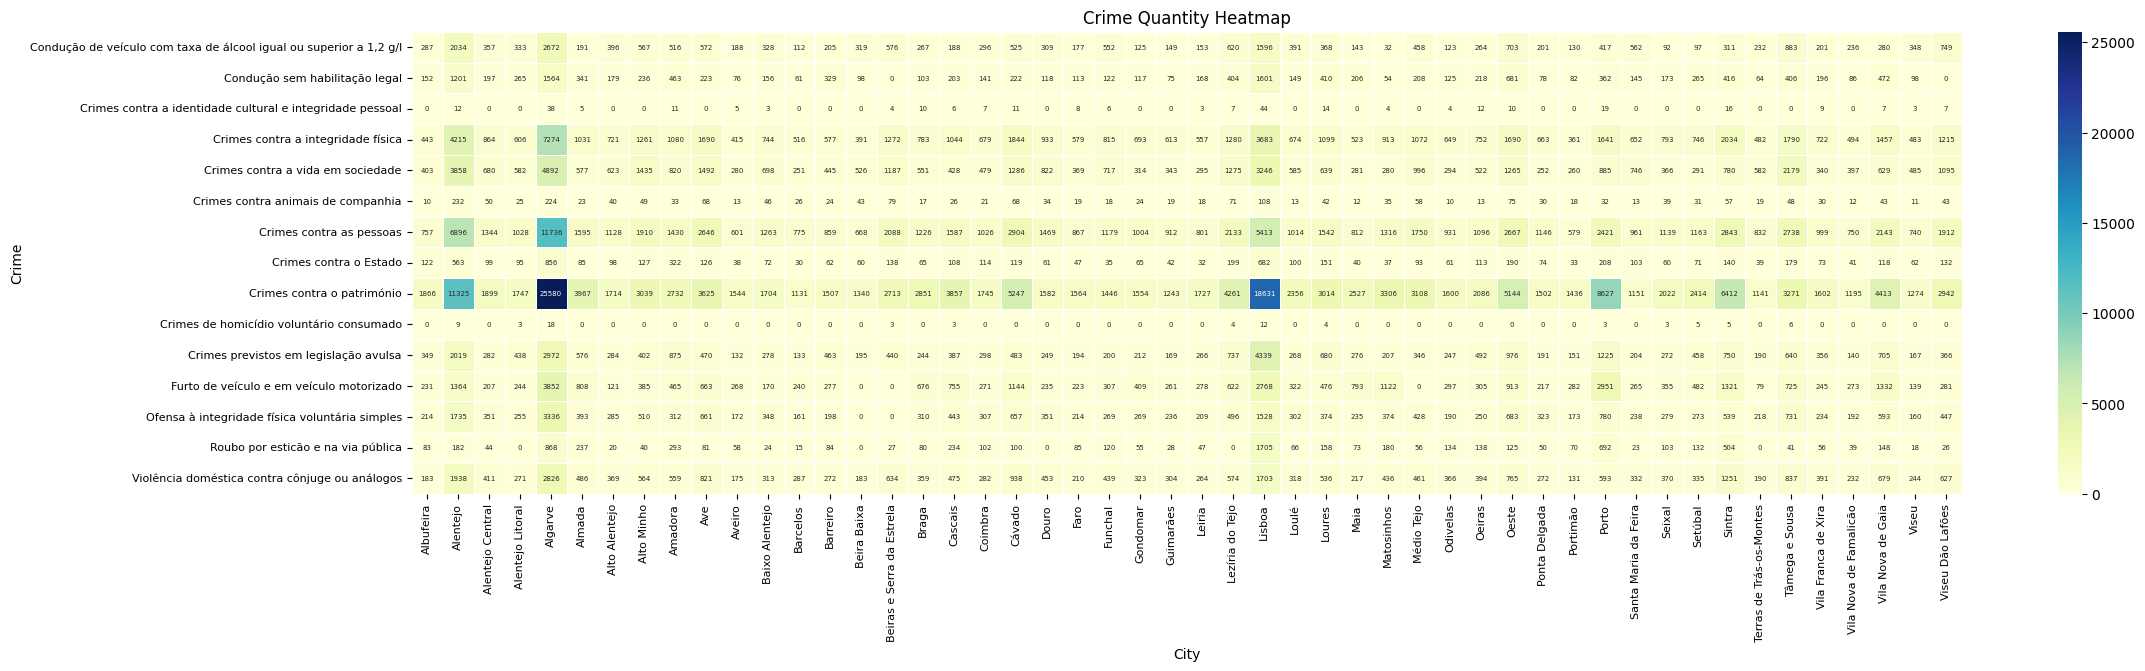

In [11]:
# Pivot the DataFrame with aggregation (sum in this case)
matrix = df_top5.pivot_table(index='crime', columns='city', values='value', aggfunc='sum')

# Sort the columns (cities) alphabetically
matrix = matrix.reindex(sorted(matrix.columns), axis=1)

# Create a heatmap
plt.figure(figsize=(25, 6))
sns.heatmap(matrix, cmap='YlGnBu', annot=True, annot_kws={"size": 5}, fmt='d', linewidths=0.5)

plt.title('Crime Quantity Heatmap')
plt.xlabel('City')
plt.ylabel('Crime')

# Display the plot with HTML to enable scrolling
plt.xticks(rotation=90, fontsize=8)
plt.yticks(fontsize=8)

plt.show()

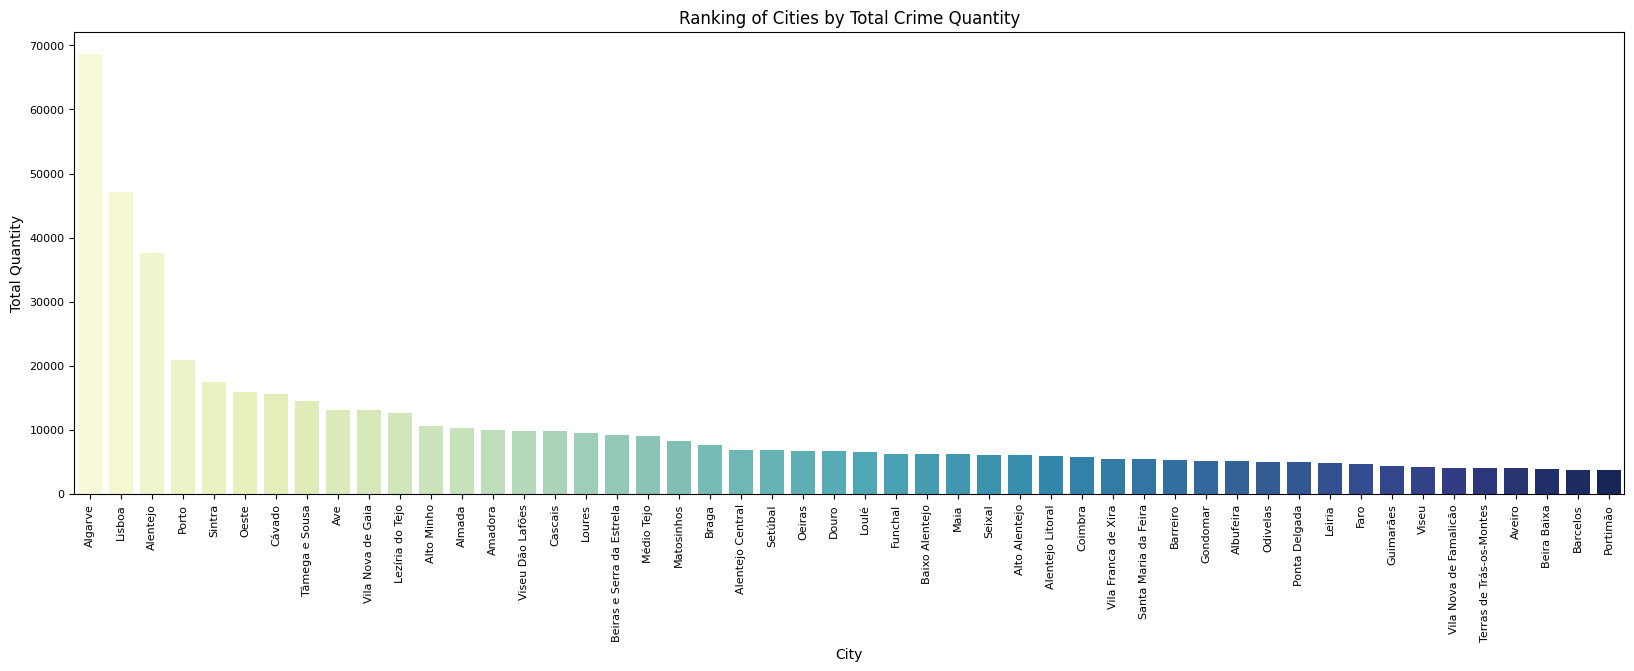

In [12]:
# Sum the values across all crimes for each city
city_totals = df_top5.groupby('city')['value'].sum()

# Sort the cities based on total quantities in descending order
ranked_cities = city_totals.sort_values(ascending=False)

# Create a bar chart to visualize the ranked cities
plt.figure(figsize=(20, 6))
sns.barplot(x=ranked_cities.index, y=ranked_cities.values, palette='YlGnBu')

plt.title('Ranking of Cities by Total Crime Quantity')
plt.xlabel('City')
plt.ylabel('Total Quantity')

plt.xticks(rotation=90, fontsize=8)
plt.yticks(fontsize=8)

plt.show()
